# Проект: Рекомендательная система постов в социальной сети

## Описание проекта

- Задача: необходимо создать модель для сервиса, который будет для каждого юзера в любой момент времени возвращать посты, которые пользователю покажут в его ленте соцсети.

- Оценка качества модели: качество написанного алгоритма будет проверяться по метрике hitrate@5

- Описание данных:

    1. Таблица user_data - Cодержит информацию о всех пользователях соц.сети:
        - age	Возраст пользователя (в профиле)
        - city	Город пользователя (в профиле)
        - country	Страна пользователя (в профиле)
        - exp_group	Экспериментальная группа: некоторая зашифрованная категория
        - gender	Пол пользователя
        - user_id	Уникальный идентификатор пользователя
        - os	Операционная система устройства, с которого происходит пользование соц.сетью
        - source	Пришел ли пользователь в приложение с органического трафика или с рекламы

    2. Таблица post_text_df - Содержит информацию о постах и уникальный ID каждой единицы с соответствующим ей текстом и топиком
        - id	Уникальный идентификатор поста
        - text	Текстовое содержание поста
        - topic	Основная тематика

    3. Таблица feed_data - Содержит историю о просмотренных постах для каждого юзера в изучаемый период:
        - timestamp	Время, когда был произведен просмотр
        - user_id	id пользователя, который совершил просмотр
        - post_id	id просмотренного поста
        - action	Тип действия: просмотр или лайк
        - target	1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение.


- Оптимизация HitRate@5 - целевая метрика!
    - Как устроена метрика: принимает значение 1, если среди предложенных 5 рекомендаций хотя бы 1 получила в итоге like от пользователя. Даже если все 5 предложенных постов в итоге будут оценены пользователем, все равно hitrate будет равен 1. Метрика бинарная! В противном случае, если ни один из предложенных постов не был оценен пользователем, hitrate принимает значение 0. Эту метрику мы будем максимизировать.
    - Как будем обучать модель: возьмем прокси-метрику "ROC AUC", которую будем максимизировать, а уже на основании результатов производить выбор лучших кандидатов на основании целевой метрики HitRate@5.

## Загрузка данных

In [1]:
!pip install catboost sqlalchemy statsmodels psycopg2 imblearn -qqq

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import psycopg2
import re
import seaborn as sns
import tensorflow as tf
import warnings

from catboost import CatBoostClassifier

from imblearn.under_sampling import RandomUnderSampler

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sqlalchemy import create_engine
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

pd.options.display.max_columns = 500
warnings.filterwarnings('ignore')

In [3]:
### Установим красивые дефолтные настройки у графиков
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 15
mlp.rcParams['axes.titlesize'] = 15
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
RANDOM_STATE = 42

In [6]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

In [7]:
user_data = pd.read_sql(
    """
    SELECT *
    FROM public.user_data;
    """,
    con=engine
)
user_data.head(2)

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads


In [8]:
post_data = pd.read_sql(
    """
    SELECT *
    FROM public.post_text_df;
    """,
    con=engine
)
post_data.head(2)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business


In [9]:
feed_data = pd.read_sql(
    """
    SELECT *
    FROM public.feed_data
    WHERE action='view'
    LIMIT 1000000;
    """,
    con=engine
)
feed_data.head(2)

,timestamp,user_id,post_id,action,target
0,2021-10-03 21:30:35,5408,3325,view,0
1,2021-10-03 21:32:48,5408,1909,view,0


## Обзор данных. EDA

In [10]:
feed_data.shape, user_data.shape, post_data.shape

((1000000, 5), (163205, 8), (7023, 3))

### User Data:

In [11]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


In [12]:
user_data.describe()

,user_id,gender,age,exp_group
count,163205.000000,163205.000000,163205.000000,163205.000000
mean,85070.371759,0.551331,27.195405,1.997598
std,48971.639950,0.497360,10.239158,1.413644
min,200.000000,0.000000,14.000000,0.000000
25%,41030.000000,0.000000,19.000000,1.000000
50%,85511.000000,1.000000,24.000000,2.000000
75%,127733.000000,1.000000,33.000000,3.000000
max,168552.000000,1.000000,95.000000,4.000000


In [13]:
user_data.describe(include=object)

,country,city,os,source
count,163205,163205,163205,163205
unique,11,3915,2,2
top,Russia,Moscow,Android,ads
freq,143035,21874,105972,101685


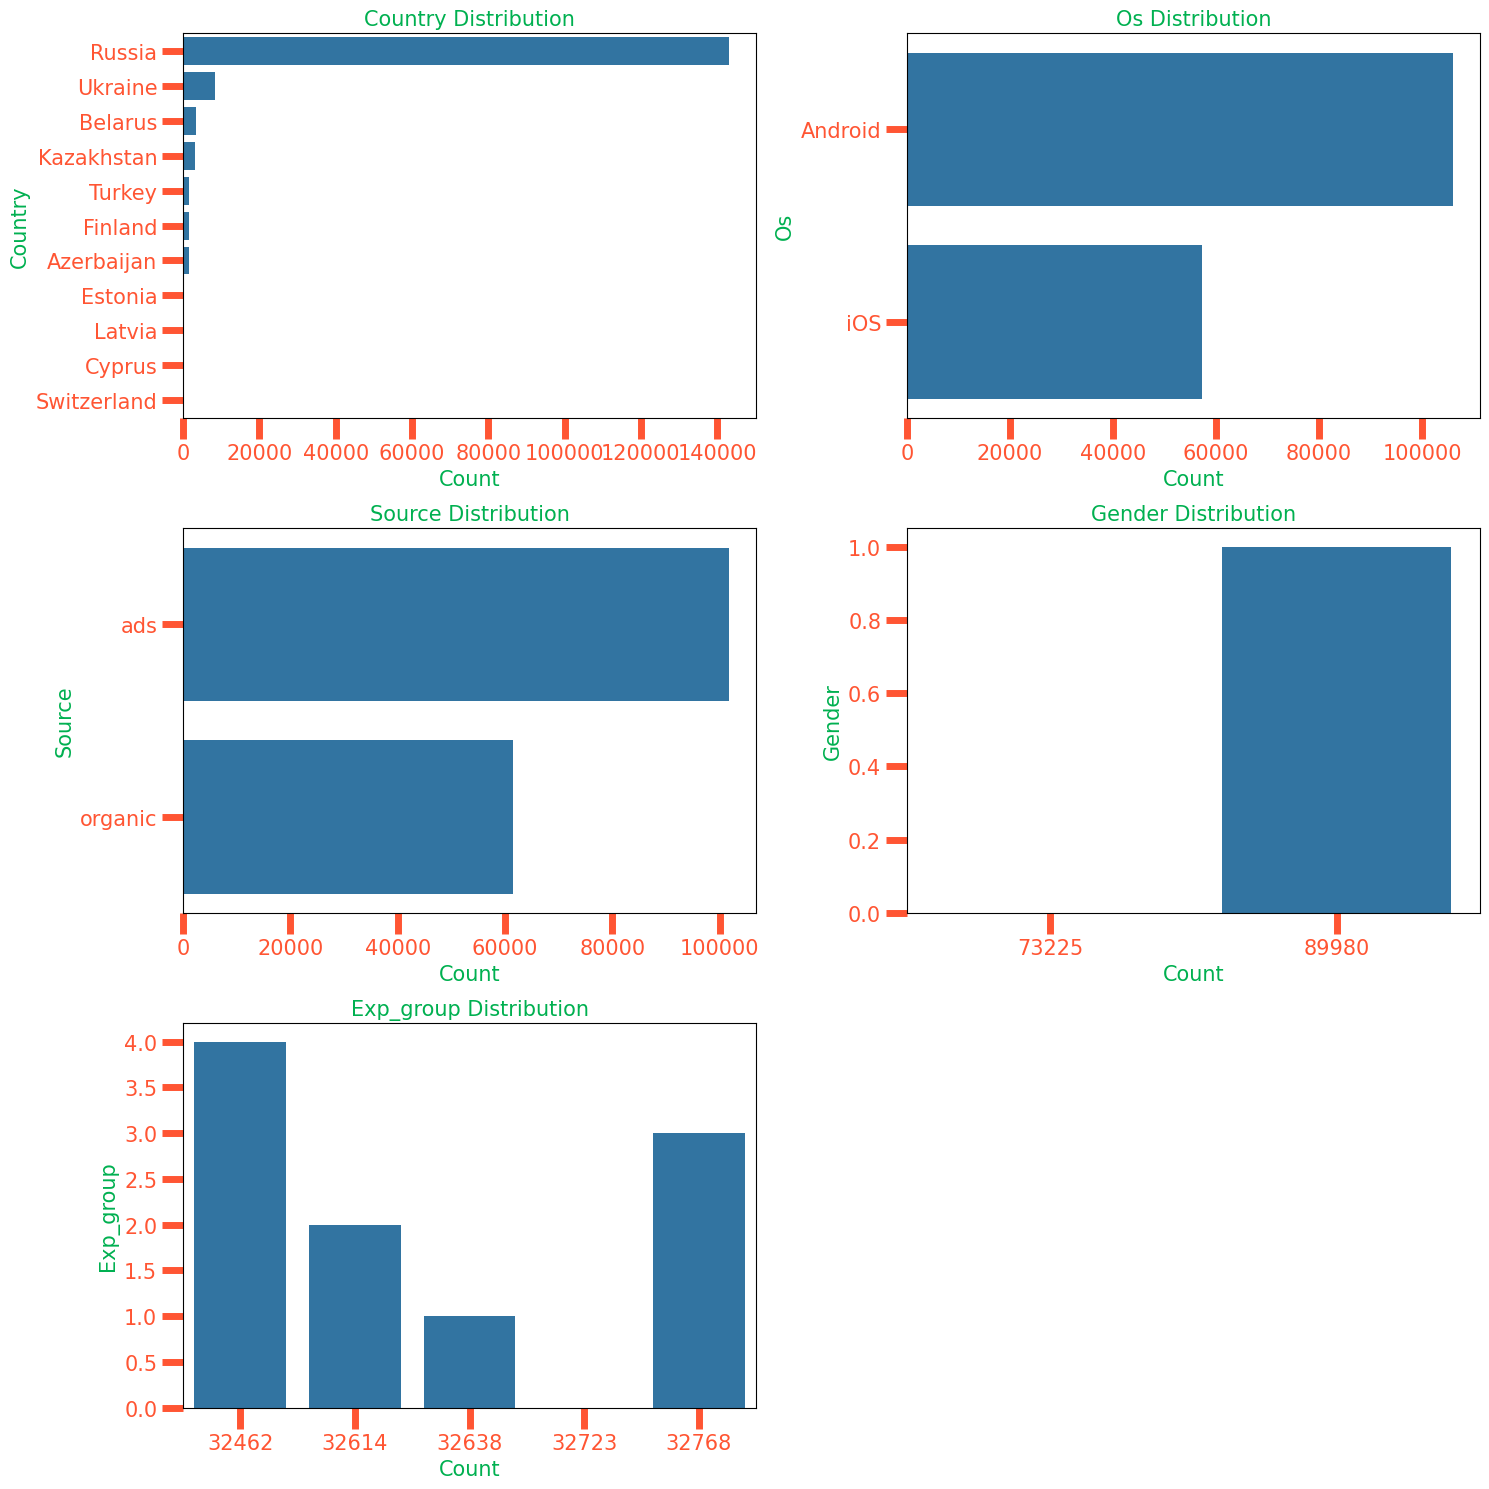

In [14]:
categorical_columns = ['country', 'os', 'source', 'gender', 'exp_group']

fig, axs = plt.subplots(len(categorical_columns)//2 + len(categorical_columns)%2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(categorical_columns):
    sns.barplot(y=user_data[col].value_counts().index, x=user_data[col].value_counts().values, ax=axs[i])
    axs[i].set_title(f'{col.capitalize()} Distribution')
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel(col.capitalize())

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

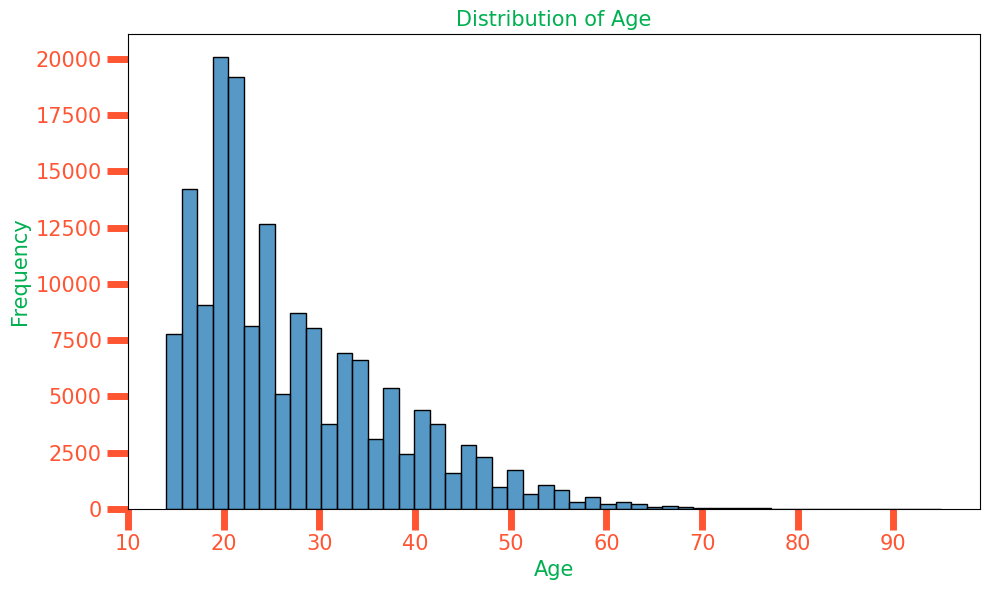

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(user_data['age'], bins=50)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [16]:
print("Top 5 most common ages:")
print(user_data['age'].value_counts().head(5))
print("\nTop 5 least common ages:")
print(user_data['age'].value_counts(ascending=True).head(5))

Top 5 most common ages:
age
20    10280
21    10139
19     9802
22     9049
18     9034
Name: count, dtype: int64

Top 5 least common ages:
age
95    1
92    1
83    1
86    1
85    1
Name: count, dtype: int64


### Post Data:

In [17]:
post_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  7023 non-null   int64 
 1   text     7023 non-null   object
 2   topic    7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


In [18]:
post_data.describe()

,post_id
count,7023.000000
mean,3666.533817
std,2109.613383
min,1.000000
25%,1849.500000
50%,3668.000000
75%,5492.000000
max,7319.000000


In [19]:
post_data.describe(include=object)

,text,topic
count,7023,7023
unique,6924,7
top,Sony PSP console hits US in March\n\nUS gamers...,movie
freq,2,3000


In [20]:
post_data['topic'].value_counts()

topic
movie            3000
covid            1799
business          510
sport             510
politics          417
tech              401
entertainment     386
Name: count, dtype: int64

In [21]:
duplicated_rows = post_data[post_data.duplicated(subset='text', keep=False)]
duplicated_rows.sort_values(by='text')

,post_id,text,topic
2705,2186,2D Metal Slug offers retro fun\n\nLike some dr...,tech
2631,2137,2D Metal Slug offers retro fun\n\nLike some dr...,tech
2901,2312,Apple attacked over sources row\n\nCivil liber...,tech
2827,2290,Apple attacked over sources row\n\nCivil liber...,tech
2910,2317,Apple iPod family expands market\n\nApple has ...,tech
...,...,...,...
2376,1950,Warning over tsunami aid website\n\nNet users ...,tech
2436,1997,Web radio takes Spanish rap global\n\nSpin the...,tech
2843,2279,Web radio takes Spanish rap global\n\nSpin the...,tech
2433,1994,What high-definition will do to DVDs\n\nFirst ...,tech


### Feed Data:

In [22]:
feed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1000000 non-null  datetime64[ns]
 1   user_id    1000000 non-null  int64         
 2   post_id    1000000 non-null  int64         
 3   action     1000000 non-null  object        
 4   target     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 38.1+ MB


In [23]:
feed_data.describe()

,timestamp,user_id,post_id,target
count,1000000,1000000.000000,1000000.000000,1000000.000000
mean,2021-11-14 20:54:42.343984128,106681.847445,3396.748045,0.121812
min,2021-10-01 06:06:45,5408.000000,1.000000,0.000000
25%,2021-10-23 11:18:19,91503.000000,1529.000000,0.000000
50%,2021-11-14 13:56:58,125292.000000,3191.000000,0.000000
75%,2021-12-07 12:36:05,138851.000000,5207.000000,0.000000
max,2021-12-29 23:43:27,145980.000000,7319.000000,1.000000
std,NaN,46461.294863,2093.570794,0.327069


In [24]:
start_data = feed_data['timestamp'].min()
end_data = feed_data['timestamp'].max()
print(f"Начальная дата: {start_data}")
print(f"Конечная дата: {end_data}")

time_range = end_data - start_data
print("Временной диапазон данных: ", time_range)

Начальная дата: 2021-10-01 06:06:45
Конечная дата: 2021-12-29 23:43:27
Временной диапазон данных:  89 days 17:36:42


## Создание признаков

In [25]:
def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = ''.join(c for c in text if c.isalnum() or c.isspace())  # Удаление знаков препинания
    words = word_tokenize(text)  # Токенизация текста
    words = [word for word in words if word not in stop_words]  # Удаление стоп-слов
    lemmatizer = WordNetLemmatizer()  # Лемматизация
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Удаление неалфавитных символов
def remove_nonalpha(texts):
    clean_texts = []
    for text in texts:
        clean_texts.append(re.sub(r'[^a-zA-Z\s]', '', text))
    return clean_texts

tqdm.pandas()
post_data['processed_text'] = post_data['text'].progress_apply(preprocess_text)
post_data['processed_text'] = remove_nonalpha(post_data['processed_text'])

post_data.head()

100%|██████████| 7023/7023 [00:08<00:00, 787.83it/s]


,post_id,text,topic,processed_text
0,1,UK economy facing major risks\n\nThe UK manufa...,business,uk economy facing major risk uk manufacturing ...
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,aid climate top davos agenda climate change fi...
2,3,Asian quake hits European shares\n\nShares in ...,business,asian quake hit european share share europe le...
3,4,India power shares jump on debut\n\nShares in ...,business,india power share jump debut share india large...
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,lacroix label bought u firm luxury good group ...


In [26]:
# отфильтруем редкие слова, которые встречаются меньше 5 раз
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5)
tfidf_matrix = tfidf_vectorizer.fit_transform(post_data['processed_text'])

In [27]:
# Преобразуем матрицу TF-IDF в DataFrame
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

# Объединим с post_data
tfidf_df['post_id'] = post_data['post_id']
post_data_tfidf = pd.concat([post_data, tfidf_df], axis=1)

# Удалим столбцы «text», «processed_text», а также второй столбец «post_id»
post_data_tfidf = post_data_tfidf.loc[:, ~post_data_tfidf.columns.duplicated()]
post_data_tfidf.drop(columns=['text', 'processed_text'], inplace=True)

In [28]:
def find_best_k(text_embeddings):
    all_scores = {}
    for i in tqdm(range(5, 21)):
        kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
        labels = kmeans.fit_predict(text_embeddings)
        score = silhouette_score(text_embeddings, labels)
        all_scores[i] = score

    best_k = max(all_scores, key=all_scores.get)
    return best_k

In [29]:
best_k = find_best_k(tfidf_matrix)
best_k

100%|██████████| 16/16 [00:50<00:00,  3.17s/it]


8

In [30]:
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE)
kmeans.fit(tfidf_matrix)

KMeans(random_state=42)

In [31]:
post_data_tfidf['cluster'] = kmeans.labels_
post_data_tfidf.head()

,post_id,topic,ability,able,absolutely,access,according,account,accused,across,act,acting,action,actor,actress,actually,add,added,adult,affair,africa,age,agency,ago,agreed,ahead,aid,air,airline,album,allow,almost,alone,along,already,also,although,always,amazing,america,american,among,amount,analyst,announced,annual,another,anyone,anything,appeal,apple,area,around,art,artist,ask,asked,attack,attempt,audience,australian,authority,available,average,award,away,awful,baby,back,bad,ball,band,bank,based,battle,bbc,beat,beautiful,became,become,becomes,begin,beginning,behind,belief,believe,benefit,best,better,beyond,bid,big,biggest,bill,bit,black,blair,blood,bn,board,body,book,boost,boring,bos,bought,box,boy,break,bring,britain,british,broadband,brother,brought,brown,budget,building,business,buy,call,called,came,camera,campaign,cant,car,card,care,career,case,cash,cast,centre,certain,certainly,chairman,challenge,champion,championship,chance,chancellor,change,channel,character,charge,charles,chart,chelsea,chief,child,china,choice,christmas,cinema,city,claim,class,classic,clear,clearly,close,club,coach,come,comedy,comic,coming,comment,commission,committee,common,community,company,compared,competition,complete,completely,computer,concern,conference,connection,conservative,consumer,content,continue,control,copy,cost,could,couldnt,council,country,couple,course,court,covid,create,created,credit,crime,criminal,critic,cup,current,currently,customer,cut,dark,data,date,daughter,david,day,de,dead,deal,death,debt,december,decided,decision,definitely,demand,democrat,department,despite,detail,development,device,dialogue,didnt,died,different,difficult,digital,directed,direction,director,disaster,doctor,documentary,doesnt,dollar,done,dont,double,doubt,dr,drama,...,script,search,season,second,secretary,security,see,seeing,seem,seemed,seems,seen,sense,sent,september,sequel,sequence,series,serious,service,set,setting,seven,several,sex,share,shes,short,shot,show,showed,showing,shown,side,sign,similar,simple,simply,since,singer,single,sir,sister,site,situation,six,slow,small,smith,social,society,software,sold,someone,something,sometimes,son,song,soon,sort,sound,south,special,speech,speed,spend,spending,spent,spokesman,sport,stage,stand,standard,star,start,started,state,statement,station,stay,step,still,stock,stop,store,story,straight,street,strong,student,studio,study,stuff,stupid,style,subject,success,summer,sunday,support,supposed,sure,survey,system,take,taken,taking,talent,talk,talking,target,tax,team,technology,television,tell,ten,term,terrible,test,th,thats,theme,there,theyre,thing,think,thinking,third,though,thought,threat,three,throughout,thursday,time,title,today,together,told,tony,took,top,tory,total,totally,tough,tour,towards,town,track,trade,trial,tried,true,truly,try,trying,tuesday,turn,turned,tv,two,type,uk,understand,union,united,university,us,use,used,user,using,usual,usually,value,version,via,victim,victory,video,view,viewer,virus,voice,vote,voter,wale,want,wanted,war,warned,wasnt,waste,watch,watched,watching,water,way,web,website,wednesday,week,weekend,well,went,west,whether,white,whole,whose,wife,williams,win,window,winner,winning,wish,within,without,woman,wonder,wonderful,wont,word,work,worked,worker,working,world,worse,worst,worth,would,wouldnt,writer,writing,written,wrong,year,yearold,yes,yet,york,youll,young,youre,yukos,cluster
0,1,business,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.065936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.035950,0.058222,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046744,0.000000,0.0,0.0,0.073346,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.049058,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.062977,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0

In [32]:
def add_user_features(user_df):
    # user_df['age_gender'] = user_df['age'] * user_df['gender']
    user_df['source_ad'] = user_df['source'].apply(lambda x: 1 if x == 'ads' else 0)
    return user_df

user_data = add_user_features(user_data)
user_data.head()

,user_id,gender,age,country,city,exp_group,os,source,source_ad
0,200,1,34,Russia,Degtyarsk,3,Android,ads,1
1,201,0,37,Russia,Abakan,0,Android,ads,1
2,202,1,17,Russia,Smolensk,4,Android,ads,1
3,203,0,18,Russia,Moscow,1,iOS,ads,1
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,1


In [33]:
feed_data_with_clusters = feed_data.merge(post_data_tfidf[['post_id', 'cluster']], on='post_id', how='left')

In [34]:
def calculate_user_cluster_features(user_id, feed_data):
    user_interactions = feed_data[feed_data['user_id'] == user_id]
    cluster_counts = user_interactions['cluster'].value_counts(normalize=True)
    cluster_features = {f'cluster_{i}_ratio': cluster_counts.get(i, 0) for i in range(best_k)}
    return pd.Series(cluster_features)

user_cluster_features = user_data['user_id'].apply(calculate_user_cluster_features, feed_data=feed_data_with_clusters)
user_cluster_features = pd.DataFrame(user_cluster_features)
user_data = pd.concat([user_data, user_cluster_features], axis=1)
user_data.head()

,user_id,gender,age,country,city,exp_group,os,source,source_ad,cluster_0_ratio,cluster_1_ratio,cluster_2_ratio,cluster_3_ratio,cluster_4_ratio,cluster_5_ratio,cluster_6_ratio,cluster_7_ratio
0,200,1,34,Russia,Degtyarsk,3,Android,ads,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201,0,37,Russia,Abakan,0,Android,ads,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,202,1,17,Russia,Smolensk,4,Android,ads,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,203,0,18,Russia,Moscow,1,iOS,ads,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Подготовка данных для обучения модели

In [35]:
feed_data = feed_data.sort_values(by='timestamp')
split_index = int(len(feed_data) * 0.8)

train_data = feed_data.iloc[:split_index]
test_data = feed_data.iloc[split_index:]

print(f"Training data: {len(train_data)} rows")
print(f"Test data: {len(test_data)} rows")
print()
print(f"Train start timestamp: {train_data['timestamp'].min()}")
print(f"Train end timestamp: {train_data['timestamp'].max()}")
print()
print(f"Test start timestamp: {test_data['timestamp'].min()}")
print(f"Test end timestamp: {test_data['timestamp'].max()}")

Training data: 800000 rows
Test data: 200000 rows

Train start timestamp: 2021-10-01 06:06:45
Train end timestamp: 2021-12-11 20:12:53

Test start timestamp: 2021-12-11 20:13:19
Test end timestamp: 2021-12-29 23:43:27


In [36]:
# Добавление признаков пользователя
train_data = train_data.merge(user_data, on='user_id', how='left')
test_data = test_data.merge(user_data, on='user_id', how='left')
# Добавление признаков поста
train_data = train_data.merge(post_data_tfidf, on='post_id', how='left')
test_data = test_data.merge(post_data_tfidf, on='post_id', how='left')

In [37]:
# Переместим 'user_id' и 'post_id' в индекс для дальнейшего использования в hitrate@5
train_data = train_data.set_index(['user_id', 'post_id'])
test_data = test_data.set_index(['user_id', 'post_id'])
train_data.head()

timestamp action_x  target_x  gender  age_x  \
user_id post_id                                                         
119314  3618    2021-10-01 06:06:45     view         0       1     25   
        2634    2021-10-01 06:08:35     view         0       1     25   
        1180    2021-10-01 06:10:44     view         0       1     25   
        1653    2021-10-01 06:11:22     view         0       1     25   
119104  3368    2021-10-01 06:13:37     view         0       0     33   

                country_x            city_x  exp_group       os   source  \
user_id post_id                                                            
119314  3618       Russia  Saint Petersburg          0      iOS  organic   
        2634       Russia  Saint Petersburg          0      iOS  organic   
        1180       Russia  Saint Petersburg          0      iOS  organic   
        1653       Russia  Saint Petersburg          0      iOS  organic   
119104  3368       Russia            Kstovo          1  Android  organic   

                 source_ad  cluster_0_ratio  cluster_1_ratio  cluster_2_ratio  \
user_id post_id                                                                 
119314  3618             0         0.155172         0.125000         0.163793   
        2634             0         0.155172         0.125000         0.163793   
        1180             0         0.155172         0.125000         0.163793   
        1653             0         0.155172         0.125000         0.163793   
119104  3368             0         0.162210         0.085561         0.126560   

                 cluster_3_ratio  cluster_4_ratio  cluster_5_ratio  \
user_id post_id                                                      
119314  3618            0.163793         0.094828         0.103448   
        2634            0.163793         0.094828         0.103448   
        1180            0.163793         0.094828         0.103448   
        1653            0.163793         0.094828         0.103448   
119104  3368            0.096257         0.167558         0.128342   

                 cluster_6_ratio  cluster_7_ratio     topic  ability  able  \
user_id post_id                                                              
119314  3618            0.077586         0.116379     covid      0.0   0.0   
        2634            0.077586         0.116379     covid      0.0   0.0   
        1180            0.077586         0.116379  politics      0.0   0.0   
        1653            0.077586         0.116379     sport      0.0   0.0   
119104  3368            0.169340         0.064171     covid      0.0   0.0   

                 absolutely  access  according  account  accused   across  \
user_id post_id                                                             
119314  3618       0.000000     0.0   0.000000      0.0      0.0  0.00000   
        2634       0.000000     0.0   0.000000      0.0      0.0  0.00000   
        1180       0.000000     0.0   0.086172      0.0      0.0  0.00000   
        1653       0.082314     0.0   0.000000      0.0      0.0  0.00000   
119104  3368       0.000000     0.0   0.000000      0.0      0.0  0.29821   

                 act  acting  action_y  actor  actress  actually  add  \
user_id post_id                                                         
119314  3618     0.0     0.0       0.0    0.0      0.0  0.000000  0.0   
        2634     0.0     0.0       0.0    0.0      0.0  0.000000  0.0   
        1180     0.0     0.0       0.0    0.0      0.0  0.039731  0.0   
        1653     0.0     0.0       0.0    0.0      0.0  0.000000  0.0   
119104  3368     0.0     0.0       0.0    0.0      0.0  0.000000  0.0   

                    added  adult  affair  africa  age_y    agency       ago  \
user_id post_id                                                               
119314  3618     0.000000    0.0     0.0     0.0    0.0  0.000000  0.000000   
        2634     0.000000    0.0     0.0     0.0    0.0  0.000000  0.000000   
       

In [38]:
train_data = train_data.rename(columns={
    'action_x': 'action',
    'target_x': 'target',
    'age_x': 'age',
    'country_x': 'country',
    'city_x': 'city'
})

In [39]:
test_data = test_data.rename(columns={
    'action_x': 'action',
    'target_x': 'target',
    'age_x': 'age',
    'country_x': 'country',
    'city_x': 'city'
})

In [40]:
# Создание обучающей выборки
X_train = train_data.drop(columns=['target', 'timestamp', 'action'])
y_train = train_data['target']

In [41]:
# Создание тестовой выборки
X_test = test_data.drop(columns=['target', 'timestamp', 'action'])
y_test = test_data['target']

In [42]:
X_test.head()

,,gender,age,country,city,exp_group,os,source,source_ad,cluster_0_ratio,cluster_1_ratio,cluster_2_ratio,cluster_3_ratio,cluster_4_ratio,cluster_5_ratio,cluster_6_ratio,cluster_7_ratio,topic,ability,able,absolutely,access,according,account,accused,across,act,acting,action_y,actor,actress,actually,add,added,adult,affair,africa,age_y,agency,ago,agreed,ahead,aid,air,airline,album,allow,almost,alone,along,already,also,although,always,amazing,america,american,among,amount,analyst,announced,annual,another,anyone,anything,appeal,apple,area,around,art,artist,ask,asked,attack,attempt,audience,australian,authority,available,average,award,away,awful,baby,back,bad,ball,band,bank,based,battle,bbc,beat,beautiful,became,become,becomes,begin,beginning,behind,belief,believe,benefit,best,better,beyond,bid,big,biggest,bill,bit,black,blair,blood,bn,board,body,book,boost,boring,bos,bought,box,boy,break,bring,britain,british,broadband,brother,brought,brown,budget,building,business,buy,call,called,came,camera,campaign,cant,car,card,care,career,case,cash,cast,centre,certain,certainly,chairman,challenge,champion,championship,chance,chancellor,change,channel,character,charge,charles,chart,chelsea,chief,child,china,choice,christmas,cinema,city_y,claim,class,classic,clear,clearly,close,club,coach,come,comedy,comic,coming,comment,commission,committee,common,community,company,compared,competition,complete,completely,computer,concern,conference,connection,conservative,consumer,content,continue,control,copy,cost,could,couldnt,council,country_y,couple,course,court,covid,create,created,credit,crime,criminal,critic,cup,current,currently,customer,cut,dark,data,date,daughter,david,day,de,dead,deal,death,debt,december,decided,decision,definitely,demand,democrat,department,despite,detail,development,device,dialogue,didnt,died,different,difficult,...,script,search,season,second,secretary,security,see,seeing,seem,seemed,seems,seen,sense,sent,september,sequel,sequence,series,serious,service,set,setting,seven,several,sex,share,shes,short,shot,show,showed,showing,shown,side,sign,similar,simple,simply,since,singer,single,sir,sister,site,situation,six,slow,small,smith,social,society,software,sold,someone,something,sometimes,son,song,soon,sort,sound,south,special,speech,speed,spend,spending,spent,spokesman,sport,stage,stand,standard,star,start,started,state,statement,station,stay,step,still,stock,stop,store,story,straight,street,strong,student,studio,study,stuff,stupid,style,subject,success,summer,sunday,support,supposed,sure,survey,system,take,taken,taking,talent,talk,talking,target_y,tax,team,technology,television,tell,ten,term,terrible,test,th,thats,theme,there,theyre,thing,think,thinking,third,though,thought,threat,three,throughout,thursday,time,title,today,together,told,tony,took,top,tory,total,totally,tough,tour,towards,town,track,trade,trial,tried,true,truly,try,trying,tuesday,turn,turned,tv,two,type,uk,understand,union,united,university,us,use,used,user,using,usual,usually,value,version,via,victim,victory,video,view,viewer,virus,voice,vote,voter,wale,want,wanted,war,warned,wasnt,waste,watch,watched,watching,water,way,web,website,wednesday,week,weekend,well,went,west,whether,white,whole,whose,wife,williams,win,window,winner,winning,wish,within,without,woman,wonder,wonderful,wont,word,work,worked,worker,working,world,worse,worst,worth,would,wouldnt,writer,writing,written,wrong,year,yearold,yes,yet,york,youll,young,youre,yukos,cluster
user_id,post_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
91553,5671,0,22,Russia,Magn

In [43]:
# Разделим признаки на категориальные и числовые для дальнейшей обработки
cat_features = ['gender', 'country', 'city', 'exp_group', 'os', 'source', 'source_ad', 'cluster', 'topic']
num_features = ['age'] + [f'cluster_{i}_ratio' for i in range(best_k)] + list(tfidf_feature_names)

In [44]:
# Закодируем категориальные признаки
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    label_encoders[col] = le

    X_test[col] = X_test[col].astype(str)
    X_test[col] = X_test[col].apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )

In [45]:
# Нормализуем все признаки для Логистической Регрессии и Нейронной Сети
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
print(f"Баланс классов обучающей выборки: {y_train.value_counts(normalize=True)}")
print()
print(f"Баланс классов тестовой выборки: {y_test.value_counts(normalize=True)}")

Баланс классов обучающей выборки: target
0    0.882465
1    0.117535
Name: proportion, dtype: float64

Баланс классов тестовой выборки: target
0    0.86108
1    0.13892
Name: proportion, dtype: float64


## Тренировка моделей и оценка их качества


In [47]:
def calculate_hitrate(preds, probs, X_data, y, top=5):
    results = pd.DataFrame({
        'preds': preds,
        'probs': probs,
        'target': y
    }, index=X_data.index)

    hit_count = 0
    unique_users = results.index.get_level_values('user_id').unique()

    for user in unique_users:
        user_data = results.xs(user, level='user_id')
        top_posts = user_data.sort_values(by='probs', ascending=False).head(top)

        if top_posts['target'].sum() > 0:
            hit_count += 1

    hitrate = round(hit_count / len(unique_users), 2)
    return hitrate

In [48]:
# Создадим словарь для сборки результатов всех моделей
results = {}

In [49]:
# Logistic Regression
log_model = LogisticRegression(
    max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced'
    )
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
y_pred_log_prob = log_model.predict_proba(X_test_scaled)[:, 1]

In [50]:
results['Logistic Regression'] = {
    'Accuracy': round(accuracy_score(y_test, y_pred_log), 2),
    'ROC AUC': round(roc_auc_score(y_test, y_pred_log_prob), 2),
    'Hitrate@5 на тесте': calculate_hitrate(
        y_pred_log, y_pred_log_prob, X_test, y_test
        ),
}
results

{'Logistic Regression': {'Accuracy': 0.53,
  'ROC AUC': 0.54,
  'Hitrate@5 на тесте': 0.57}}

In [51]:
print(f"""LogisticRegression classification report on test:\n
{classification_report(y_test, y_pred_log, digits=2)}""")

LogisticRegression classification report on test:

              precision    recall  f1-score   support

           0       0.87      0.53      0.66    172216
           1       0.15      0.53      0.24     27784

    accuracy                           0.53    200000
   macro avg       0.51      0.53      0.45    200000
weighted avg       0.77      0.53      0.60    200000



In [52]:
# CatBoost Classifier
cat_model = CatBoostClassifier(
    iterations=1000,
    eval_metric='AUC',
    loss_function='Logloss',
    random_seed=RANDOM_STATE,
    auto_class_weights = 'Balanced')

cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)
y_pred_cat_prob = cat_model.predict_proba(X_test)[:, 1]

Learning rate set to 0.178877
0:	total: 190ms	remaining: 3m 9s
1:	total: 294ms	remaining: 2m 26s
2:	total: 401ms	remaining: 2m 13s
3:	total: 512ms	remaining: 2m 7s
4:	total: 620ms	remaining: 2m 3s
5:	total: 736ms	remaining: 2m 1s
6:	total: 844ms	remaining: 1m 59s
7:	total: 944ms	remaining: 1m 57s
8:	total: 1.05s	remaining: 1m 55s
9:	total: 1.14s	remaining: 1m 52s
10:	total: 1.24s	remaining: 1m 51s
11:	total: 1.33s	remaining: 1m 49s
12:	total: 1.44s	remaining: 1m 49s
13:	total: 1.54s	remaining: 1m 48s
14:	total: 1.65s	remaining: 1m 48s
15:	total: 1.75s	remaining: 1m 47s
16:	total: 1.86s	remaining: 1m 47s
17:	total: 1.97s	remaining: 1m 47s
18:	total: 2.07s	remaining: 1m 46s
19:	total: 2.16s	remaining: 1m 45s
20:	total: 2.26s	remaining: 1m 45s
21:	total: 2.37s	remaining: 1m 45s
22:	total: 2.46s	remaining: 1m 44s
23:	total: 2.55s	remaining: 1m 43s
24:	total: 2.67s	remaining: 1m 44s
25:	total: 2.77s	remaining: 1m 43s
26:	total: 2.87s	remaining: 1m 43s
27:	total: 2.98s	remaining: 1m 43s
28:	

In [53]:
results['CatBoost'] = {
    'Accuracy': round(accuracy_score(y_test, y_pred_cat), 2),
    'ROC AUC': round(roc_auc_score(y_test, y_pred_cat_prob), 2),
    'Hitrate@5 на тесте': calculate_hitrate(y_pred_cat, y_pred_cat_prob, X_test, y_test),
}
results

{'Logistic Regression': {'Accuracy': 0.53,
  'ROC AUC': 0.54,
  'Hitrate@5 на тесте': 0.57},
 'CatBoost': {'Accuracy': 0.65, 'ROC AUC': 0.67, 'Hitrate@5 на тесте': 0.65}}

In [54]:
print(f"CatBoost classification report on test:\n {classification_report(y_test, y_pred_cat, digits=2)}")

CatBoost classification report on test:
               precision    recall  f1-score   support

           0       0.91      0.66      0.76    172216
           1       0.21      0.58      0.31     27784

    accuracy                           0.65    200000
   macro avg       0.56      0.62      0.54    200000
weighted avg       0.81      0.65      0.70    200000



In [55]:
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm_bar = tqdm(total=self.epochs, desc='Training Progress', unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm_bar.update(1)

    def on_train_end(self, logs=None):
        self.tqdm_bar.close()

In [56]:
# Neural Network с учетом дисбаланса классов
nn_model_balanced = Sequential()

nn_model_balanced.add(Dense(512, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model_balanced.add(BatchNormalization())
nn_model_balanced.add(Dropout(0.5))

nn_model_balanced.add(Dense(256, activation='relu'))
nn_model_balanced.add(BatchNormalization())
nn_model_balanced.add(Dropout(0.5))

nn_model_balanced.add(Dense(128, activation='relu'))
nn_model_balanced.add(BatchNormalization())
nn_model_balanced.add(Dropout(0.5))

nn_model_balanced.add(Dense(64, activation='relu'))
nn_model_balanced.add(BatchNormalization())
nn_model_balanced.add(Dropout(0.5))

nn_model_balanced.add(Dense(1, activation='sigmoid'))

# Вычисление весов классов для устранения дисбаланса классов
class_weights = {
    0: 1,  # вес для класса 0 (основной класс)
    1: 6   # вес для класса 1 (небольшой класс)
}

nn_model_balanced.compile(loss='binary_crossentropy',
                          optimizer=Adam(learning_rate=0.001),
                          metrics=[tf.keras.metrics.AUC()])


reduce_lr = ReduceLROnPlateau(monitor='val_auc',
                              factor=0.1,
                              patience=2,
                              min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_auc',
                               patience=5,
                               mode='max',
                               restore_best_weights=True)

nn_model_balanced.fit(X_train_scaled,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.2,
                      class_weight=class_weights,
                      callbacks=[TQDMProgressBar(), reduce_lr, early_stopping])


y_pred_nn_balanced = (
    nn_model_balanced.predict(X_test_scaled) > 0.5
    ).astype(int).flatten()

y_pred_nn_prob_balanced = nn_model_balanced.predict(X_test_scaled).flatten()

Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

Epoch 1/50
19994/20000 [============================>.] - ETA: 0s - loss: 1.0759 - auc: 0.5197

Training Progress:   2%|▏         | 1/50 [02:25<1:58:51, 145.54s/epoch]

20000/20000 [==============================] - 146s 7ms/step - loss: 1.0759 - auc: 0.5198 - val_loss: 0.5830 - val_auc: 0.5602 - lr: 0.0010
Epoch 2/50
19997/20000 [============================>.] - ETA: 0s - loss: 1.0508 - auc: 0.5844

Training Progress:   4%|▍         | 2/50 [04:46<1:54:07, 142.65s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0509 - auc: 0.5844 - val_loss: 0.5839 - val_auc: 0.6006 - lr: 0.0010
Epoch 3/50
19997/20000 [============================>.] - ETA: 0s - loss: 1.0362 - auc: 0.6153

Training Progress:   6%|▌         | 3/50 [07:06<1:50:44, 141.38s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0362 - auc: 0.6154 - val_loss: 0.5957 - val_auc: 0.6121 - lr: 0.0010
Epoch 4/50
19997/20000 [============================>.] - ETA: 0s - loss: 1.0226 - auc: 0.6360

Training Progress:   8%|▊         | 4/50 [09:26<1:48:14, 141.19s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0226 - auc: 0.6360 - val_loss: 0.5757 - val_auc: 0.6157 - lr: 1.0000e-04
Epoch 5/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0183 - auc: 0.6417

Training Progress:  10%|█         | 5/50 [11:47<1:45:38, 140.85s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0183 - auc: 0.6417 - val_loss: 0.5755 - val_auc: 0.6173 - lr: 1.0000e-04
Epoch 6/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0152 - auc: 0.6462

Training Progress:  12%|█▏        | 6/50 [14:08<1:43:19, 140.90s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0152 - auc: 0.6462 - val_loss: 0.5735 - val_auc: 0.6174 - lr: 1.0000e-05
Epoch 7/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0151 - auc: 0.6461

Training Progress:  14%|█▍        | 7/50 [16:28<1:40:55, 140.82s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0151 - auc: 0.6461 - val_loss: 0.5733 - val_auc: 0.6177 - lr: 1.0000e-05
Epoch 8/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0146 - auc: 0.6464

Training Progress:  16%|█▌        | 8/50 [18:49<1:38:35, 140.84s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0146 - auc: 0.6464 - val_loss: 0.5738 - val_auc: 0.6177 - lr: 1.0000e-05
Epoch 9/50
19999/20000 [============================>.] - ETA: 0s - loss: 1.0145 - auc: 0.6472

Training Progress:  18%|█▊        | 9/50 [21:10<1:36:12, 140.79s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0145 - auc: 0.6472 - val_loss: 0.5708 - val_auc: 0.6178 - lr: 1.0000e-05
Epoch 10/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0138 - auc: 0.6475

Training Progress:  20%|██        | 10/50 [23:30<1:33:42, 140.55s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0139 - auc: 0.6475 - val_loss: 0.5713 - val_auc: 0.6181 - lr: 1.0000e-05
Epoch 11/50
19999/20000 [============================>.] - ETA: 0s - loss: 1.0132 - auc: 0.6490

Training Progress:  22%|██▏       | 11/50 [25:49<1:31:09, 140.23s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0131 - auc: 0.6490 - val_loss: 0.5752 - val_auc: 0.6183 - lr: 1.0000e-05
Epoch 12/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0135 - auc: 0.6484

Training Progress:  24%|██▍       | 12/50 [28:09<1:28:46, 140.17s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0135 - auc: 0.6483 - val_loss: 0.5730 - val_auc: 0.6183 - lr: 1.0000e-05
Epoch 13/50
19996/20000 [============================>.] - ETA: 0s - loss: 1.0133 - auc: 0.6486

Training Progress:  26%|██▌       | 13/50 [30:30<1:26:31, 140.32s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0133 - auc: 0.6486 - val_loss: 0.5729 - val_auc: 0.6185 - lr: 1.0000e-05
Epoch 14/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0137 - auc: 0.6480

Training Progress:  28%|██▊       | 14/50 [32:50<1:24:05, 140.15s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0137 - auc: 0.6480 - val_loss: 0.5728 - val_auc: 0.6187 - lr: 1.0000e-05
Epoch 15/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0132 - auc: 0.6483

Training Progress:  30%|███       | 15/50 [35:11<1:21:53, 140.40s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0132 - auc: 0.6483 - val_loss: 0.5697 - val_auc: 0.6188 - lr: 1.0000e-05
Epoch 16/50
19997/20000 [============================>.] - ETA: 0s - loss: 1.0120 - auc: 0.6501

Training Progress:  32%|███▏      | 16/50 [37:31<1:19:31, 140.33s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0121 - auc: 0.6501 - val_loss: 0.5701 - val_auc: 0.6187 - lr: 1.0000e-05
Epoch 17/50
20000/20000 [==============================] - ETA: 0s - loss: 1.0120 - auc: 0.6505

Training Progress:  34%|███▍      | 17/50 [39:52<1:17:16, 140.51s/epoch]

20000/20000 [==============================] - 141s 7ms/step - loss: 1.0120 - auc: 0.6505 - val_loss: 0.5739 - val_auc: 0.6189 - lr: 1.0000e-05
Epoch 18/50
19994/20000 [============================>.] - ETA: 0s - loss: 1.0122 - auc: 0.6498

Training Progress:  36%|███▌      | 18/50 [42:12<1:14:51, 140.37s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0123 - auc: 0.6498 - val_loss: 0.5717 - val_auc: 0.6190 - lr: 1.0000e-05
Epoch 19/50
19999/20000 [============================>.] - ETA: 0s - loss: 1.0117 - auc: 0.6506

Training Progress:  38%|███▊      | 19/50 [44:32<1:12:25, 140.19s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0117 - auc: 0.6506 - val_loss: 0.5727 - val_auc: 0.6190 - lr: 1.0000e-05
Epoch 20/50
19999/20000 [============================>.] - ETA: 0s - loss: 1.0118 - auc: 0.6507

Training Progress:  40%|████      | 20/50 [46:52<1:10:02, 140.07s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0118 - auc: 0.6507 - val_loss: 0.5711 - val_auc: 0.6191 - lr: 1.0000e-05
Epoch 21/50
19999/20000 [============================>.] - ETA: 0s - loss: 1.0115 - auc: 0.6510

Training Progress:  42%|████▏     | 21/50 [49:11<1:07:38, 139.94s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0115 - auc: 0.6510 - val_loss: 0.5727 - val_auc: 0.6192 - lr: 1.0000e-05
Epoch 22/50
19997/20000 [============================>.] - ETA: 0s - loss: 1.0115 - auc: 0.6511

Training Progress:  44%|████▍     | 22/50 [51:31<1:05:13, 139.75s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0115 - auc: 0.6510 - val_loss: 0.5722 - val_auc: 0.6193 - lr: 1.0000e-05
Epoch 23/50
19996/20000 [============================>.] - ETA: 0s - loss: 1.0110 - auc: 0.6512

Training Progress:  46%|████▌     | 23/50 [53:50<1:02:50, 139.66s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0109 - auc: 0.6512 - val_loss: 0.5712 - val_auc: 0.6194 - lr: 1.0000e-05
Epoch 24/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0110 - auc: 0.6511

Training Progress:  48%|████▊     | 24/50 [56:10<1:00:30, 139.65s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0110 - auc: 0.6511 - val_loss: 0.5749 - val_auc: 0.6196 - lr: 1.0000e-05
Epoch 25/50
19998/20000 [============================>.] - ETA: 0s - loss: 1.0106 - auc: 0.6517

Training Progress:  50%|█████     | 25/50 [58:28<58:00, 139.21s/epoch]  

20000/20000 [==============================] - 138s 7ms/step - loss: 1.0107 - auc: 0.6517 - val_loss: 0.5756 - val_auc: 0.6197 - lr: 1.0000e-05
Epoch 26/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0103 - auc: 0.6520

Training Progress:  52%|█████▏    | 26/50 [1:00:47<55:41, 139.21s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0103 - auc: 0.6520 - val_loss: 0.5709 - val_auc: 0.6196 - lr: 1.0000e-05
Epoch 27/50
19994/20000 [============================>.] - ETA: 0s - loss: 1.0110 - auc: 0.6515

Training Progress:  54%|█████▍    | 27/50 [1:03:05<53:15, 138.94s/epoch]

20000/20000 [==============================] - 138s 7ms/step - loss: 1.0110 - auc: 0.6515 - val_loss: 0.5680 - val_auc: 0.6198 - lr: 1.0000e-05
Epoch 28/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0102 - auc: 0.6523

Training Progress:  56%|█████▌    | 28/50 [1:05:25<51:00, 139.12s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0102 - auc: 0.6523 - val_loss: 0.5685 - val_auc: 0.6198 - lr: 1.0000e-05
Epoch 29/50
20000/20000 [==============================] - ETA: 0s - loss: 1.0110 - auc: 0.6520

Training Progress:  58%|█████▊    | 29/50 [1:07:44<48:41, 139.11s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0110 - auc: 0.6520 - val_loss: 0.5731 - val_auc: 0.6198 - lr: 1.0000e-05
Epoch 30/50
19996/20000 [============================>.] - ETA: 0s - loss: 1.0099 - auc: 0.6529

Training Progress:  60%|██████    | 30/50 [1:10:04<46:26, 139.34s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0099 - auc: 0.6529 - val_loss: 0.5700 - val_auc: 0.6198 - lr: 1.0000e-05
Epoch 31/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0095 - auc: 0.6537

Training Progress:  62%|██████▏   | 31/50 [1:12:22<44:03, 139.12s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0095 - auc: 0.6537 - val_loss: 0.5699 - val_auc: 0.6197 - lr: 1.0000e-05
Epoch 32/50
19998/20000 [============================>.] - ETA: 0s - loss: 1.0095 - auc: 0.6534

Training Progress:  64%|██████▍   | 32/50 [1:14:41<41:41, 138.99s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0095 - auc: 0.6534 - val_loss: 0.5694 - val_auc: 0.6200 - lr: 1.0000e-05
Epoch 33/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0092 - auc: 0.6535

Training Progress:  66%|██████▌   | 33/50 [1:17:00<39:24, 139.08s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0092 - auc: 0.6535 - val_loss: 0.5693 - val_auc: 0.6200 - lr: 1.0000e-05
Epoch 34/50
19998/20000 [============================>.] - ETA: 0s - loss: 1.0089 - auc: 0.6544

Training Progress:  68%|██████▊   | 34/50 [1:19:19<37:00, 138.81s/epoch]

20000/20000 [==============================] - 138s 7ms/step - loss: 1.0089 - auc: 0.6544 - val_loss: 0.5682 - val_auc: 0.6202 - lr: 1.0000e-05
Epoch 35/50
19999/20000 [============================>.] - ETA: 0s - loss: 1.0093 - auc: 0.6537

Training Progress:  70%|███████   | 35/50 [1:21:38<34:45, 139.01s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0093 - auc: 0.6537 - val_loss: 0.5688 - val_auc: 0.6203 - lr: 1.0000e-05
Epoch 36/50
19999/20000 [============================>.] - ETA: 0s - loss: 1.0083 - auc: 0.6548

Training Progress:  72%|███████▏  | 36/50 [1:23:57<32:24, 138.92s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0083 - auc: 0.6548 - val_loss: 0.5684 - val_auc: 0.6201 - lr: 1.0000e-05
Epoch 37/50
19994/20000 [============================>.] - ETA: 0s - loss: 1.0084 - auc: 0.6547

Training Progress:  74%|███████▍  | 37/50 [1:26:16<30:08, 139.10s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0085 - auc: 0.6547 - val_loss: 0.5664 - val_auc: 0.6203 - lr: 1.0000e-05
Epoch 38/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0082 - auc: 0.6550

Training Progress:  76%|███████▌  | 38/50 [1:28:35<27:48, 139.01s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0081 - auc: 0.6550 - val_loss: 0.5682 - val_auc: 0.6203 - lr: 1.0000e-05
Epoch 39/50
19999/20000 [============================>.] - ETA: 0s - loss: 1.0083 - auc: 0.6553

Training Progress:  78%|███████▊  | 39/50 [1:30:54<25:30, 139.12s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0083 - auc: 0.6553 - val_loss: 0.5666 - val_auc: 0.6204 - lr: 1.0000e-05
Epoch 40/50
20000/20000 [==============================] - ETA: 0s - loss: 1.0080 - auc: 0.6552

Training Progress:  80%|████████  | 40/50 [1:33:13<23:10, 139.04s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0080 - auc: 0.6552 - val_loss: 0.5686 - val_auc: 0.6204 - lr: 1.0000e-05
Epoch 41/50
20000/20000 [==============================] - ETA: 0s - loss: 1.0079 - auc: 0.6554

Training Progress:  82%|████████▏ | 41/50 [1:35:32<20:50, 138.95s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0079 - auc: 0.6554 - val_loss: 0.5652 - val_auc: 0.6203 - lr: 1.0000e-05
Epoch 42/50
19996/20000 [============================>.] - ETA: 0s - loss: 1.0077 - auc: 0.6560

Training Progress:  84%|████████▍ | 42/50 [1:37:51<18:32, 139.07s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0078 - auc: 0.6559 - val_loss: 0.5711 - val_auc: 0.6204 - lr: 1.0000e-05
Epoch 43/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0080 - auc: 0.6554

Training Progress:  86%|████████▌ | 43/50 [1:40:10<16:12, 138.90s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0080 - auc: 0.6554 - val_loss: 0.5698 - val_auc: 0.6205 - lr: 1.0000e-05
Epoch 44/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0075 - auc: 0.6558

Training Progress:  88%|████████▊ | 44/50 [1:42:29<13:54, 139.08s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0075 - auc: 0.6558 - val_loss: 0.5696 - val_auc: 0.6206 - lr: 1.0000e-05
Epoch 45/50
19994/20000 [============================>.] - ETA: 0s - loss: 1.0077 - auc: 0.6557

Training Progress:  90%|█████████ | 45/50 [1:44:48<11:34, 138.81s/epoch]

20000/20000 [==============================] - 138s 7ms/step - loss: 1.0077 - auc: 0.6557 - val_loss: 0.5690 - val_auc: 0.6205 - lr: 1.0000e-05
Epoch 46/50
19998/20000 [============================>.] - ETA: 0s - loss: 1.0064 - auc: 0.6575

Training Progress:  92%|█████████▏| 46/50 [1:47:06<09:14, 138.59s/epoch]

20000/20000 [==============================] - 138s 7ms/step - loss: 1.0064 - auc: 0.6575 - val_loss: 0.5698 - val_auc: 0.6207 - lr: 1.0000e-05
Epoch 47/50
19995/20000 [============================>.] - ETA: 0s - loss: 1.0070 - auc: 0.6565

Training Progress:  94%|█████████▍| 47/50 [1:49:24<06:55, 138.56s/epoch]

20000/20000 [==============================] - 138s 7ms/step - loss: 1.0070 - auc: 0.6565 - val_loss: 0.5676 - val_auc: 0.6205 - lr: 1.0000e-05
Epoch 48/50
20000/20000 [==============================] - ETA: 0s - loss: 1.0072 - auc: 0.6563

Training Progress:  96%|█████████▌| 48/50 [1:51:44<04:37, 138.85s/epoch]

20000/20000 [==============================] - 140s 7ms/step - loss: 1.0072 - auc: 0.6563 - val_loss: 0.5704 - val_auc: 0.6207 - lr: 1.0000e-05
Epoch 49/50
19993/20000 [============================>.] - ETA: 0s - loss: 1.0076 - auc: 0.6563

Training Progress:  98%|█████████▊| 49/50 [1:54:03<02:18, 138.93s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0076 - auc: 0.6563 - val_loss: 0.5680 - val_auc: 0.6208 - lr: 1.0000e-05
Epoch 50/50
19997/20000 [============================>.] - ETA: 0s - loss: 1.0071 - auc: 0.6563

Training Progress: 100%|██████████| 50/50 [1:56:22<00:00, 138.89s/epoch]

20000/20000 [==============================] - 139s 7ms/step - loss: 1.0071 - auc: 0.6563 - val_loss: 0.5715 - val_auc: 0.6208 - lr: 1.0000e-05


Training Progress: 100%|██████████| 50/50 [1:56:22<00:00, 139.64s/epoch]


6250/6250 [==============================] - 13s 2ms/step


In [57]:
results['Neural Network balanced'] = {
    'Accuracy': round(accuracy_score(y_test, y_pred_nn_balanced), 2),
    'ROC AUC': round(roc_auc_score(y_test, y_pred_nn_prob_balanced), 2),
    'Hitrate@5 на тесте': calculate_hitrate(
        y_pred_nn_balanced,
        y_pred_nn_prob_balanced,
        X_test, y_test),
}
results

{'Logistic Regression': {'Accuracy': 0.53,
  'ROC AUC': 0.54,
  'Hitrate@5 на тесте': 0.57},
 'CatBoost': {'Accuracy': 0.65, 'ROC AUC': 0.67, 'Hitrate@5 на тесте': 0.65},
 'Neural Network balanced': {'Accuracy': 0.63,
  'ROC AUC': 0.62,
  'Hitrate@5 на тесте': 0.67}}

In [58]:
print(f"""Neural Netword balanced classification report
on test:\n {classification_report(y_test, y_pred_nn_balanced, digits=2)}""")

Neural Netword balanced classification report 
on test:
               precision    recall  f1-score   support

           0       0.90      0.65      0.75    172216
           1       0.20      0.53      0.29     27784

    accuracy                           0.63    200000
   macro avg       0.55      0.59      0.52    200000
weighted avg       0.80      0.63      0.69    200000



In [59]:
# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results).T
results_df

,Accuracy,ROC AUC,Hitrate@5 на тесте
Logistic Regression,0.53,0.54,0.57
CatBoost,0.65,0.67,0.65
Neural Network balanced,0.63,0.62,0.67


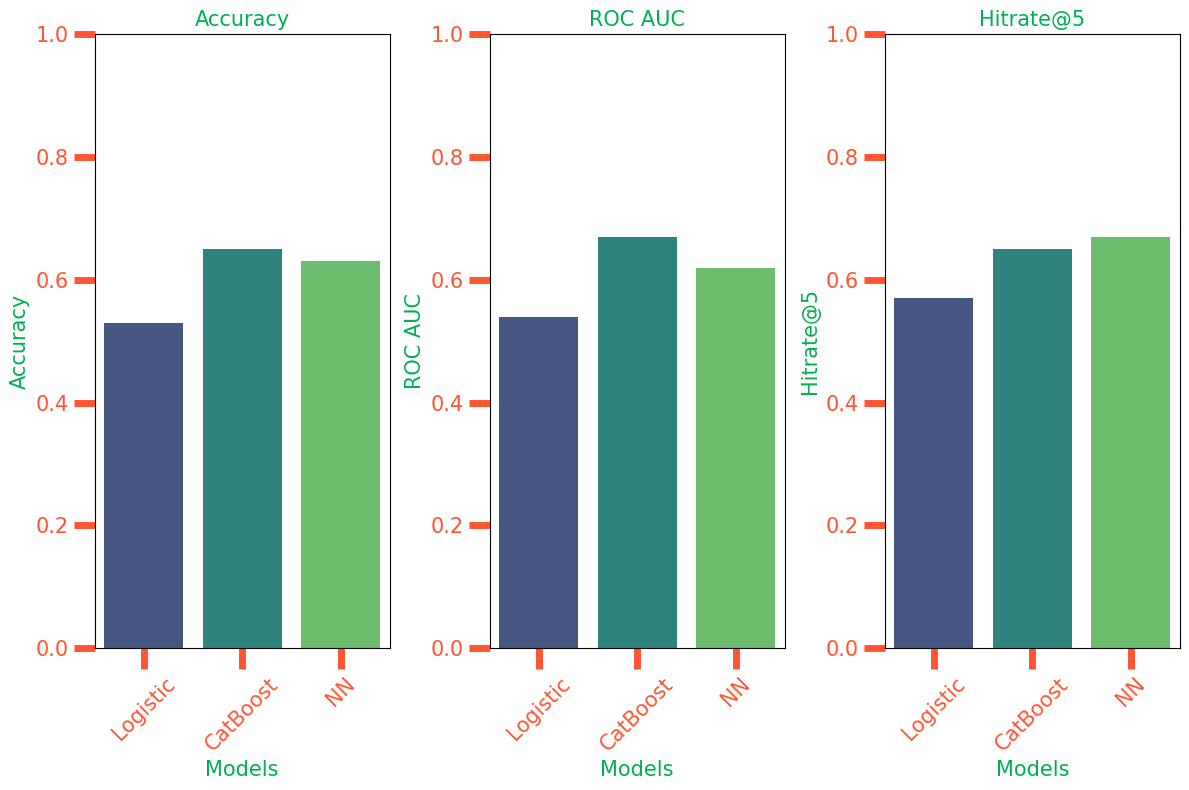

In [60]:
# Изменим имена на короткие для графиков
short_names = {
    'Logistic Regression': 'Logistic',
    'CatBoost': 'CatBoost',
    'Neural Network balanced': 'NN',
}


results_df_short = results_df.rename(index=short_names)


plt.figure(figsize=(12, 8))


plt.subplot(1, 3, 1)
sns.barplot(x=results_df_short.index,
            y=results_df['Accuracy'],
            palette='viridis')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(rotation=45)


plt.subplot(1, 3, 2)
sns.barplot(x=results_df_short.index,
            y=results_df['ROC AUC'],
            palette='viridis')
plt.ylim(0, 1)
plt.title('ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Models')
plt.xticks(rotation=45)


plt.subplot(1, 3, 3)
sns.barplot(x=results_df_short.index,
            y=results_df['Hitrate@5 на тесте'],
            palette='viridis')
plt.ylim(0, 1)
plt.title('Hitrate@5')
plt.ylabel('Hitrate@5')
plt.xlabel('Models')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Вывод:

- Модель логистической регрессии имеет низкое качество предсказания, особенно для класса 1, с низкими значениями precision и F1-score:
    - Precision: 0.15
    - Recall: 0.53
    - F1-score: 0.24
Общий ROC AUC показатель, равный 0.54, указывает на плохую способность модели разделять классы, целевая метрика Hitrate@5 на тесте = 0.57

- Модель CatBoost показывает улучшенные результаты по сравнению с логистической регрессией. Precision и F1-score для класса 1 выше:
    - Precision: 0.21
    - Recall: 0.58
    - F1-score: 0.31
А ROC AUC равен 0.67, что указывает на лучшую способность модели разделять классы, целевая метрика Hitrate@5 на тесте = 0.65

- Сбалансированная нейронная сеть показывает результаты, сопоставимые с CatBoost. Она незначительно уступает CatBoost по ROC AUC, равному 0.62. Несмотря на это, нейронная сеть демонстрирует улучшение в отношении способности предсказывать класс 1 по сравнению с логистической регрессией:
    - Precision: 0.20
    - Recall: 0.53
    - F1-score: 0.29
Также нейронная сеть достигает более высокий по сравнению с логистической регрессией и CatBoost Hitrate@5 на тесте  = 0.67

- Таким образом, модель CatBoost показала наилучшие результаты среди рассмотренных моделей по большинству метрик, включая Accuracy, ROC AUC, и F1-score для класса 1. Однако, сбалансированная нейронная сеть также продемонстрировала хорошие результаты по данным метрикам, а также показала самый высокий результат по целевой метрике Hitrate@5 и является в данном случае лучшей моделью. В дальнейшем можно попытаться более тонко настроить нейронную сеть и увеличить сложность архитектуры.

